In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import pandas as pd
from scipy.signal import argrelextrema

In [2]:
#get our data!
import requests

data_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
r = requests.get(data_link)
open("time_series_covid19_confirmed_global.csv" , 'wb').write(r.content)

#or just clone from here: https://github.com/CSSEGISandData/COVID-19

339771

In [3]:
filename = "time_series_covid19_confirmed_global.csv"

df = pd.read_csv(
            filename,
            sep=',',
            error_bad_lines=False,
            header = 0,
            index_col = False          
           )

dates_x = [datetime.datetime.strptime(i, "%m/%d/%y") for i in df.columns[5:]]
#[5:] - remove 1st date because we go from total cases to daily cases by shifting valuse by 1 day

cases_total_y = df.loc[df['Country/Region'] == "Ukraine"].values.tolist()[0][4:]
cases_daily_y = [j-i for i, j in zip(cases_total_y, cases_total_y[1:])]

days_to_skip = len([i for i in cases_daily_y if i<1])
print("days_to_skip =", days_to_skip)

dates_x = dates_x[days_to_skip:]
cases_daily_y = cases_daily_y[days_to_skip:]
print(dates_x[-1])
print(len(dates_x))

days_to_skip = 53
2020-11-10 00:00:00
240


In [4]:
def get_poly(x,y,deg=4):
    poly_coefts = np.polyfit(x, y, deg)
    #print(poly_coefts)
    poly_coefts = np.flip(poly_coefts, axis = 0)
    return(np.polynomial.polynomial.Polynomial(poly_coefts))

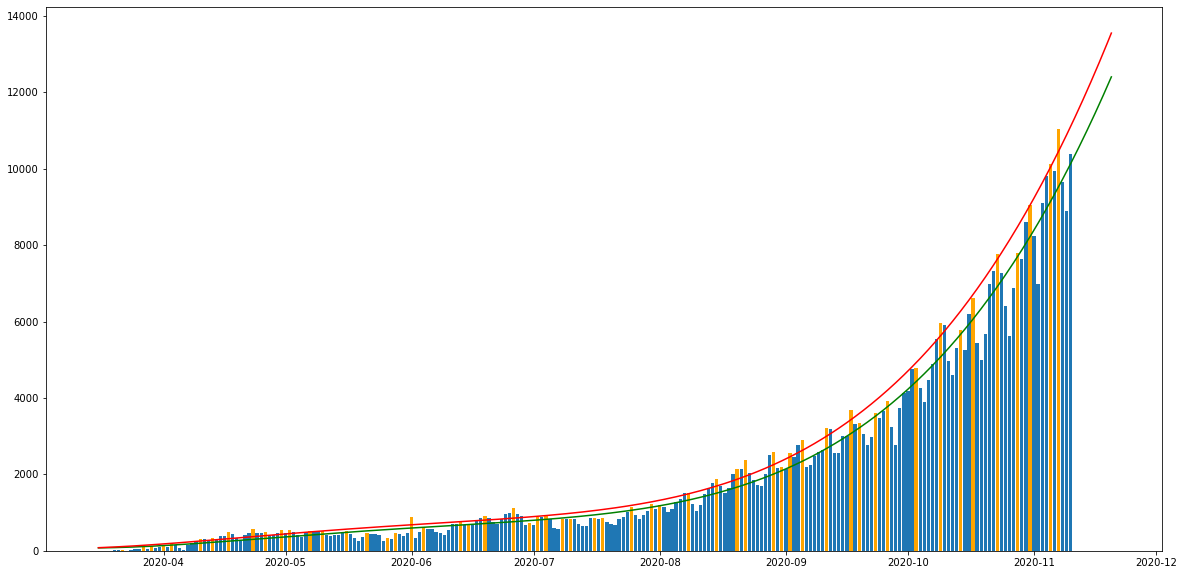

In [5]:
extra_days = 10
x = np.array(range(len(cases_daily_y)))
x_extra = np.array(range(len(cases_daily_y) + extra_days))

extra_dates_x = [dates_x[0] + datetime.timedelta(days=i) for i in range(len(x_extra))]

#approximate mid case scenario
mypoly = get_poly(x, cases_daily_y, 4)
mid_case_scenario_y = mypoly(x_extra)

#get positions of local maximums
local_max_x = argrelextrema(np.asarray(cases_daily_y), np.greater)[0]

#approximate peaks 
local_max_y = [cases_daily_y[i] for i in local_max_x]
local_max_dates = [dates_x[i] for i in local_max_x]
mypoly = get_poly(local_max_x, local_max_y, 4)
max_scenario_y = mypoly(x_extra) 

plt.rcParams["figure.figsize"] = [20,10]

fig = plt.figure()
plt.bar(dates_x, cases_daily_y)
plt.bar(local_max_dates, local_max_y, color="orange")
plt.plot(extra_dates_x, mid_case_scenario_y, c="green")
plt.plot(extra_dates_x, max_scenario_y, c="red")

plt.show()

In [6]:
for i in local_max_dates[-7:]:
    print(i)

2020-10-14 00:00:00
2020-10-17 00:00:00
2020-10-23 00:00:00
2020-10-28 00:00:00
2020-10-31 00:00:00
2020-11-05 00:00:00
2020-11-07 00:00:00


In [7]:
for i,j in zip(extra_dates_x[-extra_days:],max_scenario_y[-extra_days:]):
    print(i,j)

2020-11-11 00:00:00 11338.697098316294
2020-11-12 00:00:00 11569.069242575411
2020-11-13 00:00:00 11803.29344202042
2020-11-14 00:00:00 12041.413013539066
2020-11-15 00:00:00 12283.471511691427
2020-11-16 00:00:00 12529.512728709988
2020-11-17 00:00:00 12779.580694499571
2020-11-18 00:00:00 13033.719676637389
2020-11-19 00:00:00 13291.974180373016
2020-11-20 00:00:00 13554.388948628388


In [10]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(cases_daily_y, mid_case_scenario_y[:len(cases_daily_y)], squared=False)
rmse

360.85385379297844